In [30]:
import matplotlib.pyplot as plt

import numpy as np
from numpy import pi

from scipy.integrate import solve_ivp

from numba import jit, float64

In [19]:
# Fonction pour passer de 4 tableau à un seul et réciproquement
@jit
def join(r_x, r_y, v_x, v_y):
    return np.concatenate((r_x, r_y, v_x, v_y))

@jit
def split(y):
    N = len(y)//4
    return y[:N], y[N:2*N], y[2*N:3*N], y[3*N:4*N]

In [34]:
m = 9
q = 1
k_x = 1
k_y = 1.3

kappa=1

k_B = 1
T = 1

@jit
def force_piege(r_x, r_y):
    return -k_x*r_x, -k_y*r_y

@jit
def energie_piege(r_x, r_y):
    return np.sum(k_x*r_x**2/2 + k_y*r_y**2/2)

@jit
def force_coulomb(r_x, r_y):
    N = len(r_x)
    f_x = np.zeros(N)
    f_y = np.zeros(N)
    for i in range(N):
        tot_x, tot_y = 0, 0
        for j in range(N):
            if i!=j:
                d2 = (r_x[i]-r_x[j])**2 + (r_y[i]-r_y[j])**2
                coef = kappa*q**2/(np.sqrt(d2)**3)
                tot_x += coef*(r_x[i]-r_x[j])
                tot_y += coef*(r_y[i]-r_y[j])
        f_x[i] = tot_x
        f_y[i] = tot_y
    return f_x, f_y

@jit
def energie_coulomb(r_x, r_y):
    N = len(r_x)
    total = 0
    for i in range(N-1):
        for j in range(i+1, N):
            d2 = (r_x[i]-r_x[j])**2 + (r_y[i]-r_y[j])**2
            total += kappa*q**2/np.sqrt(d2)
    return total


# Calcul de l'énergie
def energie_cinetique(r_x, r_y, v_x, v_y):
    return np.sum(.5*m*v_x**2 + .5*m*v_y**2)
    
def energie_totale(r_x, r_y, v_x, v_y):
    return (energie_coulomb(r_x, r_y) +
            energie_piege(r_x, r_y) +
            energie_cinetique(r_x, r_y, v_x, v_y))

alpha = 0.1
@jit
def force_friction(r_x, r_y, v_x, v_y):
    return -alpha*v_x, 0*v_y

#@jit('UniTuple(float64[:], 2)(float64[:], float64[:], float64[:], float64[:])')
@jit
def force_totale(r_x, r_y, v_x, v_y):
    piege = force_piege(r_x, r_y)
    coulomb = force_coulomb(r_x, r_y)
    friction = force_friction(r_x, r_y, v_x, v_y)
    return piege[0]+coulomb[0]+friction[0], piege[1]+coulomb[1]+friction[0]


@jit
def f(t, y):
    r_x, r_y, v_x, v_y = split(y)
    f_x, f_y = force_totale(r_x, r_y, v_x, v_y)
    return join(v_x, v_y, f_x/m, f_y/m)

In [38]:
N = 99

r_x_0 = np.random.normal(size=N)
r_y_0 = np.random.normal(size=N)
v_x_0 = np.random.normal(scale=1/np.sqrt(m), size=N)
v_y_0 = np.random.normal(scale=1/np.sqrt(m), size=N)

t_max = 1500
t_eval=np.linspace(0, t_max, 400)
#res = solve_ivp(f, [0, t_max], join(r_x_0, r_y_0, v_x_0, v_y_0), t_eval=t_eval)
%time res = solve_ivp(f, [0, t_max], join(r_x_0, r_y_0, v_x_0, v_y_0), t_eval=t_eval)

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.59 s


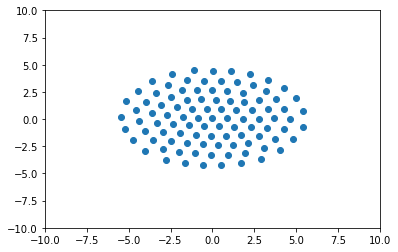

In [26]:
from IPython.display import HTML
import matplotlib.animation

fig, ax = plt.subplots()
l, = ax.plot(split(res.y[:,0])[0], split(res.y[:,0])[1], 'o')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

def animate(i):
    r_x, r_y, v_x, v_y = split(res.y[:,i])
    l.set_data(r_x, r_y)

ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate, 
                                         frames=len(res.t),
                                        interval=100)


HTML(ani.to_jshtml())

In [29]:
force_totale.signatures

[(array(float64, 1d, C),
  array(float64, 1d, C),
  array(float64, 1d, C),
  array(float64, 1d, C))]